# London Battle of the Neighborhoods
## IBM Data Science Capstone Project

This notebook will be used for the final peer-graded assignment of the capstone project of the IBM Data Science Professional Certificate.

## Setup

### Importing necessary packages

In [44]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas import json_normalize
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium
import json
from sklearn.cluster import KMeans
import branca
import branca.colormap as cm
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import geocoder
import seaborn as sns


print('Libraries imported!')

Libraries imported!


#### Define Foursquare credentials and version

### Download income data

In [2]:
# Download .xlsx containing tax payer income for each borough
df_income = pd.read_excel('https://data.london.gov.uk/download/average-income-tax-payers-borough/392e86d4-f1d3-4f06-a6a5-7fcd0fd65948/income-of-tax-payers.xlsx'
                          , sheet_name='Total Income')

# Display the first entries
df_income

,Unnamed: 0,Unnamed: 1,1999-00,Unnamed: 3,Unnamed: 4,2000-01,Unnamed: 6,Unnamed: 7,2001-02,Unnamed: 9,Unnamed: 10,2002-03,Unnamed: 12,Unnamed: 13,2003-04,Unnamed: 15,Unnamed: 16,2004-05,Unnamed: 18,Unnamed: 19,2005-06,Unnamed: 21,Unnamed: 22,2006-07,Unnamed: 24,Unnamed: 25,2007-08,Unnamed: 27,Unnamed: 28,2009-10,Unnamed: 30,Unnamed: 31,2010-11,Unnamed: 33,Unnamed: 34,2011-12,Unnamed: 36,Unnamed: 37,2012-13,Unnamed: 39,Unnamed: 40,2013-14,Unnamed: 42,Unnamed: 43,2014-15,Unnamed: 45,Unnamed: 46,2015-16,Unnamed: 48,Unnamed: 49,2016-17,Unnamed: 51,Unnamed: 52,2017-18,Unnamed: 54,Unnamed: 55
0,Code,Area,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £,Number of Individuals,Mean £,Median £
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E09000001,City of London,10000,109800,40400,10000,137000,65000,12000,92900,38300,11000,78700,37000,10000,85800,39200,10000,95600,44400,10000,90600,49300,10000,99200,49000,10000,102000,58500,9,137000,61900,8000,127000,61300,8000,117000,51600,9000,131000,58300,9000,151000,65300,9000,144000,61100,10000,142000,60000,12000,157000,57300,11000,148000,60000
3,E09000002,Barking and Dagenham,62000,16200,15100,71000,18100,15600,56000,18600,16200,67000,19100,17000,67000,18800,17400,77000,19400,16600,83000,20600,17900,77000,20600,17600,78000,21300,18600,76,23100,19400,69000,22500,19400,73000,22800,19600,74000,23700,20100,77000,24600,21000,74000,25500,21800,83000,25900,22100,88000,26700,23300,85000,27400,23900
4,E09000003,Barnet,161000,26800,18700,156000,30800,19400,159000,30400,18700,150000,32300,19700,150000,33900,20000,155000,32800,19900,161000,35600,21200,173000,36700,20400,173000,38700,22000,167,41600,24300,176000,38800,24100,179000,39200,24200,172000,41000,25800,167000,45500,26800,175000,45800,27100,178000,49000,27700,180000,48600,28800,188000,49500,28700
5,E09000004,Bexley,105000,20500,17200,116000,19800,17300,112000,22000,18300,114000,21500,17800,113000,21900,17700,124000,22300,17700,121000,24000,19400,123000,24600,19600,123000,26700,19800,117,27600,22100,114000,27400,22600,114000,28300,22300,115000,28600,23100,118000,29600,24400,122000,30200,24400,127000,30900,24500,125000,32300,26100,122000,33500,26900
6,E09000005,Brent,122000,20000,16500,130000,22200,16800,127000,21100,16500,116000,21700,16400,119000,22500,16800,137000,21800,16500,135000,23200,17600,144000,24600,18200,161000,24700,18300,145,26100,19600,146000,26700,19700,149000,27400,20200,144000,28300,20600,150000,29700,21300,147000,31200,22700,154000,32600,23200,155000,34100,24100,155000,35400,24700
7,E09000006,Bromley,163000,25100,18500,167000,26400,19500,164000,27400,19100,160000,27700,20100,150000,29200,21400,169000,29200,20900,173000,31400,22400,177000,32800,23000,181000,34400,23200,163,36500,24900,161000,35900,25800,168000,36400,25100,169000,37200,26900,173000,39000,27200,168000,40400,28100,171000,43500,29800,172000,44000,30400,174000,45500,32000
8,E09000007,Camden,85000,39000,20500,107000,40000,19700,101000,42800,19800,96000,43000,21700,90000,45700,21300,97000,50200,23200,97000,56200,24200,101000,60200,25900,107000,69800,26900,103,68900,28400,101000,67100,29400,104000,69300,30400,105000,71200,31600,99000,78900,32000,104000,79200,33100,103000,85000,34400,103000,88000,35500,101000,9260

#### We are interested in the median annual household income estimate for the last year recorded - 2017/2018, for all London boroughs: Code E0900001 - E0900033

In [3]:
# Create a new dataframe with the relevant information
df_income_2018 = pd.DataFrame({'Borough': df_income['Unnamed: 1'],
                               'Code': df_income['Unnamed: 0'],
                              'Median Household Income 2018': df_income['Unnamed: 55']})

# Remove all rows which contain codes not starting with E09. This will include unwanted headers.
df_income_2018.drop(df_income_2018[df_income_2018['Code'].str[:3] != 'E09'].index, inplace=True)

# Reset the index
df_income_2018.reset_index(drop=True, inplace=True)

# Display first rows and the shape
print(df_income_2018.shape)
df_income_2018

(33, 3)


,Borough,Code,Median Household Income 2018
0,City of London,E09000001,60000
1,Barking and Dagenham,E09000002,23900
2,Barnet,E09000003,28700
3,Bexley,E09000004,26900
4,Brent,E09000005,24700
5,Bromley,E09000006,32000
6,Camden,E09000007,37300
7,Croydon,E09000008,27500
8,Ealing,E09000009,26700
9,Enfield,E09000010,26300


#### Next, we replace the hyphens present in some borough names with space

In [4]:
df_income_2018['Borough'] = [borough.replace('-', ' ') for borough in df_income_2018['Borough']]

### Download population density data

In [5]:
# Download .xlsx containing population density for each borough
df_density = pd.read_excel('https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/cc4e7e08-3071-488f-bdd9-a62cb1ed1c5c/land-area-population-density-london.xlsx'
                          , sheet_name='Borough')

# Display the first entries
df_density.head()

,Unnamed: 0,Choose year,Unnamed: 2,2018,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Code,Area name,Inner/ Outer London,GLA Population estimate/ projection,Inland Area (Hectares),Total Area (Hectares),Population per hectare,Square Kilometres,Population per square kilometre,NaN,Census population (2011),Population per hectare
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E09000001,City of London,Inner,7681,290.393,314.938,26.4503,2.90393,2645.03,NaN,7400,25.4827
3,E09000002,Barking and Dagenham,Outer,212773,3610.78,3779.93,58.9271,36.1078,5892.71,NaN,185900,51.4847
4,E09000003,Barnet,Outer,397049,8674.83,8674.83,45.7702,86.7483,4577.02,NaN,356400,41.0844


#### We are interested in the population per square km^2 in 2018 for all London boroughs: Code E0900001 - E0900033

In [6]:
df_density_2018 = pd.DataFrame({'Borough': df_density['Choose year'],
                                'Code': df_density['Unnamed: 0'],
                                'Square kilometres': df_density['Unnamed: 7'],
                              'Population per km^2': df_density['Unnamed: 8']})

# Remove all rows which contain codes not starting with the string 'E09'. This will include unwanted headers.
df_density_2018.drop(df_density_2018[df_density_2018['Code'].str[:3] != 'E09'].index, inplace=True)

# Reset the index
df_density_2018.reset_index(drop=True, inplace=True)

# Display first rows and the shape
print(df_density_2018.shape)
df_density_2018

(33, 4)


,Borough,Code,Square kilometres,Population per km^2
0,City of London,E09000001,2.90393,2645.03
1,Barking and Dagenham,E09000002,36.1078,5892.71
2,Barnet,E09000003,86.7483,4577.02
3,Bexley,E09000004,60.5807,4126.71
4,Brent,E09000005,43.2326,7791.78
5,Bromley,E09000006,150.135,2216.23
6,Camden,E09000007,21.7893,11594.5
7,Croydon,E09000008,86.5036,4523.46
8,Ealing,E09000009,55.5443,6315.39
9,Enfield,E09000010,80.832,4177.77


#### Combine income and population density data

In [7]:
# Let's join the income column from df_income_2018 to df_density_2018
df_density_2018 = pd.merge(df_density_2018, df_income_2018[['Borough', 'Median Household Income 2018']], on='Borough', how='outer')

# Take a look at the dataframe
df_density_2018

,Borough,Code,Square kilometres,Population per km^2,Median Household Income 2018
0,City of London,E09000001,2.90393,2645.03,60000
1,Barking and Dagenham,E09000002,36.1078,5892.71,23900
2,Barnet,E09000003,86.7483,4577.02,28700
3,Bexley,E09000004,60.5807,4126.71,26900
4,Brent,E09000005,43.2326,7791.78,24700
5,Bromley,E09000006,150.135,2216.23,32000
6,Camden,E09000007,21.7893,11594.5,37300
7,Croydon,E09000008,86.5036,4523.46,27500
8,Ealing,E09000009,55.5443,6315.39,26700
9,Enfield,E09000010,80.832,4177.77,26300


#### Lastly, we get the coordinates of the borough centres. This will help in splitting venues in neighborhoods which are part of multiple boroughs, such as Acton - Ealing, Hammersmith and Fulham.

In [8]:
# Define a function to return latitude and longitude for a given postal code
def get_latlng(postal_code):
    
    # Initialize the location to "None"
    lat_lng_coords = None
    
    # Using a while loop to ensure all location coordinates are run until successfully geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(postal_code))
        lat_lng_coords = g.latlng
    
    return lat_lng_coords

In [9]:
borough_coords = [get_latlng(borough) for borough in df_density_2018['Borough']]
df_borough_coords = pd.DataFrame(borough_coords, columns = ['Latitude', 'Longitude'])
df_density_2018['Latitude'] = df_borough_coords['Latitude']
df_density_2018['Longitude'] = df_borough_coords['Longitude']
df_density_2018

,Borough,Code,Square kilometres,Population per km^2,Median Household Income 2018,Latitude,Longitude
0,City of London,E09000001,2.90393,2645.03,60000,51.508530,-0.125740
1,Barking and Dagenham,E09000002,36.1078,5892.71,23900,51.537452,0.072040
2,Barnet,E09000003,86.7483,4577.02,28700,51.627300,-0.253760
3,Bexley,E09000004,60.5807,4126.71,26900,51.452078,0.069931
4,Brent,E09000005,43.2326,7791.78,24700,51.609783,-0.194672
5,Bromley,E09000006,150.135,2216.23,32000,51.601511,-0.066365
6,Camden,E09000007,21.7893,11594.5,37300,51.591180,-0.165040
7,Croydon,E09000008,86.5036,4523.46,27500,51.593470,-0.083380
8,Ealing,E09000009,55.5443,6315.39,26700,51.508383,-0.305200
9,Enfield,E09000010,80.832,4177.77,26300,51.540024,-0.077502


### Scrape neighborhood names and postal codes

In [10]:
# Create a BeautifulSoup object
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

# Find all table elements in the html page
results = soup.find_all('table')

#### From exploring the html code of the page we know that the information we are interested in is contained in the 2nd table - results [1]

In [11]:
# Instantiate lists
neighborhoods = []
boroughs = []
postal_codes = []

# Process rows in table one by one
for row in results[1].findAll('tr'):                       # Each row is denoted by 'tr'
    
    cells = row.findAll('td')                              # Each cell is denoted by 'td'
    
    if len(cells)==6:                                      # Skip any rows we don't want
        
        if 'LONDON' in cells[2].text.strip():              # Only process rows where post town includes London
            
            neighborhoods.append(cells[0].text.strip())
            boroughs.append(cells[1].text.strip())
            postal_codes.append(cells[3].text.strip())
            
            
# Create a dataframe
df_london = pd.DataFrame({'Neighborhood': neighborhoods,
                   'Borough': boroughs,
                   'PostalCode': postal_codes
                  })

#### Let's take a look at the resulting dataframe

In [12]:
print(df_london.shape)
df_london.head()

(308, 3)


,Neighborhood,Borough,PostalCode
0,Abbey Wood,"Bexley, Greenwich [7]",SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]","W3, W4"
2,Aldgate,City[10],EC3
3,Aldwych,Westminster[10],WC2
4,Anerley,Bromley[11],SE20


#### Clean the trailing numbers in the Borough column and reduce multiple postal codes to a single one.

In [13]:
# Remove trailing reference numbers in the Borough column
df_london['Borough'] = df_london['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

# Remove second postal code for rows containing more than one
df_london['PostalCode'] = df_london['PostalCode'].str.split(', ', expand=True)

# Rename 'City' to 'City of London' for consistency
df_london.loc[df_london['Borough'] == 'City', 'Borough'] = 'City of London'

df_london.head()

,Neighborhood,Borough,PostalCode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Aldgate,City of London,EC3
3,Aldwych,Westminster,WC2
4,Anerley,Bromley,SE20


#### Convert postal codes to latitude and longitude

In [14]:
# Run the get_latlng function on each individual postal code
coordinates = [get_latlng(postal_code) for postal_code in df_london['PostalCode']]

# Cast into a dataframe
df_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])

# Add the latitude and longitude values to the main dataframe
df_london['Latitude'] = df_coordinates['Latitude']
df_london['Longitude'] = df_coordinates['Longitude']
df_london.head()

,Neighborhood,Borough,PostalCode,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",SE2,51.499741,0.124061
1,Acton,"Ealing, Hammersmith and Fulham",W3,51.507408,-0.127699
2,Aldgate,City of London,EC3,51.513145,-0.078733
3,Aldwych,Westminster,WC2,51.514625,-0.114860
4,Anerley,Bromley,SE20,51.482490,0.119194


### Use Foursquare to calculate the number of Italian restaurants per borough

#### Define useful functions

In [15]:
# Function to assign venue to the closest borough of the boroughs assigned to the venue's neighborhood    
def get_borough(venue_borough, venue_lat, venue_lng, borough_name_list, borough_lat_list, borough_lng_list):
    names = venue_borough.split(', ')
    
    if len(names) > 1:
        
        # Initialize lists to save distance to each matching borough
        distance = []
        matches = []
        print('Multiple boroughs found, minimizing distance')
        
        for borough, borough_lat, borough_lng in zip(borough_name_list, borough_lat_list, borough_lng_list):
            
            # Check if current borough is in names
            if borough in names:
                
                # Save borough name
                matches.append(borough)
                
                # Calculate Euclidian distance
                distance.append(np.sqrt((venue_lat - borough_lat)**2) + (venue_lng - borough_lng)**2)
                
        return matches[np.argmin(distance)]
    
    else:
        return venue_borough

# Function that requests data from Foursquare and structures venues into a dataframe for each neighborhood
def get_nearby_venues(neighborhoods, boroughs, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for neighborhood, borough, lat, lng in zip(neighborhoods, boroughs, latitudes, longitudes):
        print('Processing neighborhood: ', neighborhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,
            # Call the function to assign the venue to the single closest Borough
            get_borough(borough, v['venue']['location']['lat'], v['venue']['location']['lng'], 
                        df_density_2018['Borough'], df_density_2018['Latitude'], df_density_2018['Longitude']),
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
CLIENT_ID = 'VAW4ILF52JJ5ZLPB3FJ3DLNJ40SRDODWKNPPCDW2U0GXVTXU' 
CLIENT_SECRET = 'QEJNZ1LQTY3TGT0SGF1XNF1MA2V4PEAH5UORBCO2LANGSECJ'
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

In [17]:
df_london_venues = get_nearby_venues(neighborhoods=df_london['Neighborhood'],
                                     boroughs=df_london['Borough'],
                         latitudes=df_london['Latitude'],
                         longitudes=df_london['Longitude'],
                                    radius=2000)

print(df_london_venues.shape)
df_london_venues.head()

Processing neighborhood:  Abbey Wood
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs found, minimizing distance
Multiple boroughs 

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,Bexley,51.499741,0.124061,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,Bexley,51.499741,0.124061,Lidl,51.496152,0.118417,Supermarket
2,Abbey Wood,Bexley,51.499741,0.124061,Morrisons Thamesmead,51.507276,0.105392,Supermarket
3,Abbey Wood,Bexley,51.499741,0.124061,Sainsbury's,51.492826,0.120524,Supermarket
4,Abbey Wood,Bexley,51.499741,0.124061,wilko,51.505596,0.103845,Furniture / Home Store


#### Let's check out the different venue categories we've encountered

In [18]:
print('Number of unique categories: {}'.format(len(df_london_venues['Venue Category'].unique())))

# That's a few too many to go through manually. Let's try extracting the ones including strings 'italian', 'pasta' and 'pizza'
[category for category in df_london_venues['Venue Category'].unique() 
    if 'Pasta' in category or 'Italian' in category or 'Pizza' in category]


Number of unique categories: 315


['Pizza Place', 'Italian Restaurant']

#### We see that there are two categories of relevance to us: 'Italian Restaurant' and 'Pizza Place'

In [30]:
# Extract the useful venues and their information into a new dataframe
df_italian_venues = df_london_venues[(df_london_venues['Venue Category'] == 'Italian Restaurant') 
                                     | (df_london_venues['Venue Category'] == 'Pizza Place')]

# Reset the index and drop duplicates
df_italian_venues = df_italian_venues.drop_duplicates()
df_italian_venues.reset_index(drop=True, inplace=True)

# Let's check the df size, number of italian restaurants and pizza places, and header
print(df_italian_venues.shape)
print(df_italian_venues['Venue Category'].value_counts(dropna=False))
df_italian_venues.head()

(1022, 8)
Pizza Place           545
Italian Restaurant    477
Name: Venue Category, dtype: int64


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acton,Ealing,51.507408,-0.127699,Franco Manca,51.510909,-0.122780,Pizza Place
1,Aldgate,City of London,51.513145,-0.078733,Pizza Union,51.517699,-0.077416,Pizza Place
2,Aldgate,City of London,51.513145,-0.078733,Emilia’s,51.514611,-0.069210,Italian Restaurant
3,Aldgate,City of London,51.513145,-0.078733,Padella,51.505078,-0.089782,Italian Restaurant
4,Aldgate,City of London,51.513145,-0.078733,Padella,51.523372,-0.081676,Italian Restaurant


#### Now let's get the count of restaurants per borough

In [31]:
df_venues_grouped = df_italian_venues.groupby('Borough').count()

# Drop all columns except one
df_venues_grouped.drop(df_venues_grouped.columns[1:], axis=1, inplace=True)

# Rename column
df_venues_grouped.rename(columns={'Neighborhood': 'Count'}, inplace=True)
df_venues_grouped.reset_index(inplace=True)
df_venues_grouped

,Borough,Count
0,Barnet,103
1,Bexley,3
2,Brent,60
3,Bromley,11
4,Camden,76
5,City of London,11
6,Croydon,10
7,Ealing,16
8,Enfield,22
9,Greenwich,30


#### Next, let's join this dataframe to our df_density_2018 and df_borough_coords dataframes

In [22]:
df_venues_density = pd.merge(df_venues_grouped, df_density_2018, how='outer', on='Borough')
print('Size of df_venues_grouped: {}'.format(df_venues_grouped.shape))
print('Size of df_density_2018: {}'.format(df_density_2018.shape))
print('Size of df_venues_density: {}'.format(df_venues_density.shape))
df_venues_density

Size of df_venues_grouped: (29, 2)
Size of df_density_2018: (33, 7)
Size of df_venues_density: (33, 8)


,Borough,Count,Code,Square kilometres,Population per km^2,Median Household Income 2018,Latitude,Longitude
0,Barnet,103.0,E09000003,86.7483,4577.02,28700,51.627300,-0.253760
1,Bexley,3.0,E09000004,60.5807,4126.71,26900,51.452078,0.069931
2,Brent,60.0,E09000005,43.2326,7791.78,24700,51.609783,-0.194672
3,Bromley,11.0,E09000006,150.135,2216.23,32000,51.601511,-0.066365
4,Camden,76.0,E09000007,21.7893,11594.5,37300,51.591180,-0.165040
5,City of London,11.0,E09000001,2.90393,2645.03,60000,51.508530,-0.125740
6,Croydon,10.0,E09000008,86.5036,4523.46,27500,51.593470,-0.083380
7,Ealing,16.0,E09000009,55.5443,6315.39,26700,51.508383,-0.305200
8,Enfield,22.0,E09000010,80.832,4177.77,26300,51.540024,-0.077502
9,Greenwich,30.0,E09000011,47.3339,6048.99,27600,51.477890,-0.013340


#### Clean dataframe and calculate income and venues per km^2, which we will use to judge the neighborhoods proclivity to spend

In [23]:
# Remove the boroughs for which we have no venues (NaN in Count column) and the Code column
df_venues_density.dropna(axis='rows', inplace=True)
df_venues_density.drop(columns='Code', inplace=True)

# Calculate the income per km^2 and venues per km^2
df_venues_density['Venue Density'] = df_venues_density['Count']/df_venues_density['Square kilometres']
df_venues_density['Income Density'] = df_venues_density['Population per km^2']*df_venues_density['Median Household Income 2018']

df_venues_density

,Borough,Count,Square kilometres,Population per km^2,Median Household Income 2018,Latitude,Longitude,Venue Density,Income Density
0,Barnet,103.0,86.7483,4577.02,28700,51.627300,-0.253760,1.18734,1.31361e+08
1,Bexley,3.0,60.5807,4126.71,26900,51.452078,0.069931,0.0495207,1.11009e+08
2,Brent,60.0,43.2326,7791.78,24700,51.609783,-0.194672,1.38784,1.92457e+08
3,Bromley,11.0,150.135,2216.23,32000,51.601511,-0.066365,0.0732674,7.09193e+07
4,Camden,76.0,21.7893,11594.5,37300,51.591180,-0.165040,3.48795,4.32477e+08
5,City of London,11.0,2.90393,2645.03,60000,51.508530,-0.125740,3.78796,1.58702e+08
6,Croydon,10.0,86.5036,4523.46,27500,51.593470,-0.083380,0.115602,1.24395e+08
7,Ealing,16.0,55.5443,6315.39,26700,51.508383,-0.305200,0.288058,1.68621e+08
8,Enfield,22.0,80.832,4177.77,26300,51.540024,-0.077502,0.27217,1.09875e+08
9,Greenwich,30.0,47.3339,6048.99,27600,51.477890,-0.013340,0.633796,1.66952e+08


## Analyze the results

### Create rankings

#### Rank the boroughs from highest income per km^2 to lowest income per km^2, and from lowest number of restaurants per km^2 to highest number of restaurants per km^2. 

In [43]:
# Rank the venues per km^2 from lowest value (rank 1) to highest value (rank 27)
df_venues_density['Venue Rank'] = df_venues_density['Venue Density'].rank(method='dense', ascending=True)
# Rank the income per km^2 from highest value (rank 1) to lowest value (rank 27)
df_venues_density['Income Rank'] = df_venues_density['Income Density'].rank(method='dense', ascending=False)

# Let's take a look at the result. Ideally, we want a neighborhood with high ranks in both columns
borough_rankings = pd.DataFrame({'Borough': df_venues_density['Borough'],
                                'Venue Rank': df_venues_density['Venue Rank'],
                                'Income Rank': df_venues_density['Income Rank']})
borough_rankings

,Borough,Venue Rank,Income Rank
0,Barnet,14.0,23.0
1,Bexley,4.0,27.0
2,Brent,16.0,14.0
3,Bromley,5.0,29.0
4,Camden,28.0,6.0
5,City of London,29.0,19.0
6,Croydon,6.0,26.0
7,Ealing,8.0,16.0
8,Enfield,7.0,28.0
9,Greenwich,12.0,18.0


### Visualize the boroughs and their ranks on a Folium map

In [25]:
# Create map of London using latitude and longitude values
map_lat = 51.520500
map_lng = -0.097430

map_london = folium.Map(location=[map_lat, map_lng], zoom_start=10, tiles='Stamen Terrain')

# Set color schemes for the two ranking variables
ys = [range(len(df_venues_density['Venue Rank']))]

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                             index=[1.0, 5.0, 10.0, 15.0, 20.0, 27.0], vmin=1.0, vmax=27.0,
                             caption='Venue rank (border), Income rank (fill)')

map_london.add_child(colormap)

# Add markers to map for all neighborhoods
for lat, lng, borough, venue_rank, income_rank in zip(
    df_venues_density['Latitude'], df_venues_density['Longitude'], df_venues_density['Borough'], 
    df_venues_density['Venue Rank'], df_venues_density['Income Rank']):
    
    label = '{}, Venue: {}, Income: {}'.format(borough, venue_rank, income_rank)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color=colormap(venue_rank),
        fill=True,
        fill_color=colormap(income_rank),
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### Create a scatter plot to identify the most promising boroughs

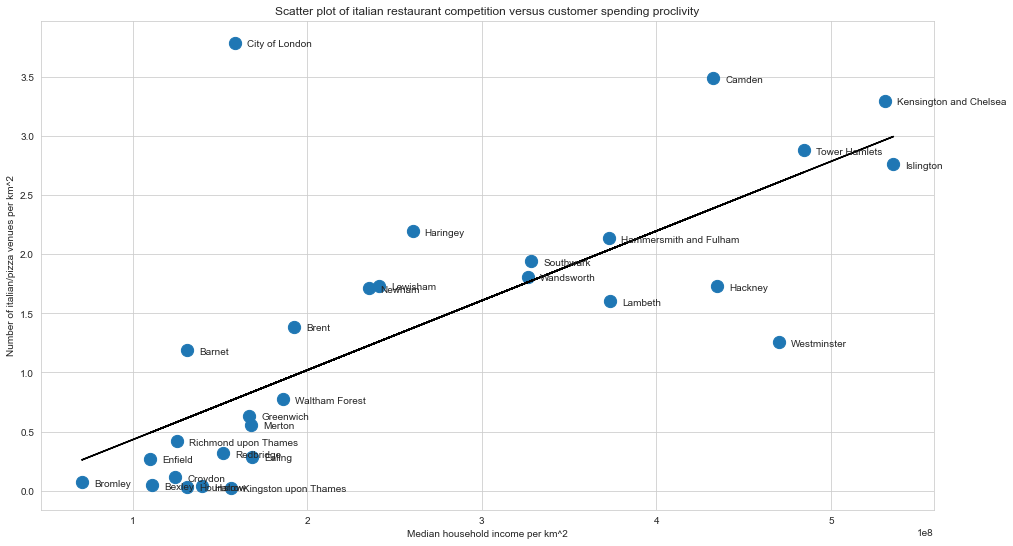

In [82]:
# Convert objects to float - required for polyfit to work
x = df_venues_density['Income Density'].astype(float)
y = df_venues_density['Venue Density'].astype(float)

# Create a trendline as a 1st order polynomial
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(x, poly1d_fn(x), '-k')
ax.scatter(x, y, s = 150)
ax.set_xlabel('Median household income per km^2')
ax.set_ylabel('Number of italian/pizza venues per km^2')
ax.set_title('Scatter plot of italian restaurant competition versus customer spending proclivity')

for i, txt in enumerate(df_venues_density['Borough']):
    plt.annotate(txt, (df_venues_density['Income Density'][i], df_venues_density['Venue Density'][i]), xytext=(12, -4),  textcoords="offset points")

plt.show()